# Imports

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord, FK5
from astropy.io import fits
from astropy import units as u
from astropy import wcs

import matplotlib.pyplot as plt

# Load data

Looking at one system, already with downloaded ugriz .fits files, first...

In [3]:
# Elliptical galaxy
uband = fits.open('J0943p0024/frame-u-000756-4-0200.fits')
gband = fits.open('J0943p0024/frame-g-000756-4-0200.fits')
rband = fits.open('J0943p0024/frame-r-000756-4-0200.fits')
iband = fits.open('J0943p0024/frame-i-000756-4-0200.fits')
zband = fits.open('J0943p0024/frame-z-000756-4-0200.fits')
coords = SkyCoord(145.8002, 0.4141723, unit=(u.deg, u.deg))

# Little Cub
#uband = fits.open('LittleCub/frame-u-002078-4-0032.fits')
#gband = fits.open('LittleCub/frame-g-002078-4-0032.fits')
#rband = fits.open('LittleCub/frame-r-002078-4-0032.fits')
#iband = fits.open('LittleCub/frame-i-002078-4-0032.fits')
#zband = fits.open('LittleCub/frame-z-002078-4-0032.fits')
#coords = SkyCoord("10:44:42.66 +63:06:02.08", unit=(u.hourangle, u.deg))

# Leo P
#uband = fits.open('LeoP/frame-u-005935-5-0260.fits')
#gband = fits.open('LeoP/frame-g-005935-5-0260.fits')
#rband = fits.open('LeoP/frame-r-005935-5-0260.fits')
#iband = fits.open('LeoP/frame-i-005935-5-0260.fits')
#zband = fits.open('LeoP/frame-z-005935-5-0260.fits')
#coords = SkyCoord("10:21:45.12 +18:05:16.88", unit=(u.hourangle, u.deg))

print (coords)

<SkyCoord (ICRS): (ra, dec) in deg
    (145.8002, 0.4141723)>


# Convert object's RA, DEC to (x,y) pixel location on image

In [6]:
def object_RADEC_to_XY(obj_RA, obj_DEC, fits_header):
    '''
    Function copied from: 
    https://acrider.wordpress.com/2015/02/04/revised-python-code-for-converting-ra-dec-to-x-y/
    
    and is closely adapted from IDL's AD2XY.PRO:
    http://www.sdss3.org/svn/repo/idlutils/tags/v5_5_5/goddard/pro/astrom/ad2xy.pro
    
    Also check out:
    https://www.galaxyzooforum.org/index.php?topic=280337.0
    https://forum.cosmoquest.org/showthread.php?137475-How-to-cut-out-a-region-from-an-SDSS-FITS-image-file
    
    Parameters
    ----------
    obj_RA : float
        object right ascension in degrees
    obj_DEC : float
        object declination in degrees
    fits_header : HDUList
        FITS file header info
        
    Returns
    -------
    obj_X : float
        object x-coordinate
    obj_Y : float
        object y-coordinate
    '''
    
    # Make sure the RA, DEC coordinate type is TAN
    if (fits_header['CTYPE1'] != 'RA---TAN') or (fits_header['CTYPE2'] != 'DEC--TAN'):
        print ('ERROR: Wrong coordinate type CTYPE1 or CTYPE2 for this object!')
        print ('\t CTYPE1 = ', fits_header['CTYPE1'])
        print ('\t CTYPE2 = ', fits_header['CTYPE2'])
        
    # These values allow translation from RA, DEC to X,Y and vice versa
    CRPIX1 = fits_header['CRPIX1'] - 1 # X of reference pixel
    CRPIX2 = fits_header['CRPIX2'] - 1 # Y of reference pixel
    CRVAL1 = fits_header['CRVAL1'] # RA of reference pixel (deg)
    CRVAL2 = fits_header['CRVAL2'] # DEC of reference pixel (deg)
    CD1_1 = fits_header['CD1_1'] # RA deg per column pixel
    CD1_2 = fits_header['CD1_2'] # RA deg per row pixel
    CD2_1 = fits_header['CD2_1'] # DEC deg per column pixel
    CD2_2 = fits_header['CD2_2'] # DEC deg per row pixel
    
    # Find the X, Y values of the galaxy's RA and DEC
    det = CD1_1 * CD2_2 - CD1_2 * CD2_1

    CD_inv_11 = CD2_2 / det
    CD_inv_12 = -CD1_2 / det
    CD_inv_21 = -CD2_1 / det
    CD_inv_22 = CD1_1 / det

    ra0 = CRVAL1 / 180.0 * np.pi
    dec0 = CRVAL2 / 180.0 * np.pi
    ra = obj_RA / 180.0 * np.pi
    dec = obj_DEC / 180.0 * np.pi

    denominator = np.sin(dec)*np.sin(dec0) + np.cos(dec)*np.cos(dec0)*np.cos(ra-ra0)

    xi = np.cos(dec) * np.sin(ra-ra0) / denominator
    eta = (np.sin(dec)*np.cos(dec0) - np.cos(dec)*np.sin(dec0)*np.cos(ra-ra0)) / denominator
    xi = xi * 180.0 / np.pi
    eta = eta * 180.0 / np.pi

    obj_X = CD_inv_11 * xi + CD_inv_12 * eta + CRPIX1
    obj_Y = CD_inv_21 * xi + CD_inv_22 * eta + CRPIX2

    return obj_X, obj_Y

## Calculate (x,y) pixel coordinates for ugriz bands

In [8]:
ux, uy = object_RADEC_to_XY(coords.ra.value, coords.dec.value, uband[0].header)
#ux, uy = wcs.utils.skycoord_to_pixel(coords, wcs.WCS(uband[0].header))
print (ux, uy)

gx, gy = object_RADEC_to_XY(coords.ra.value, coords.dec.value, gband[0].header)
print (gx, gy)

rx, ry = object_RADEC_to_XY(coords.ra.value, coords.dec.value, rband[0].header)
print (rx, ry)

ix, iy = object_RADEC_to_XY(coords.ra.value, coords.dec.value, iband[0].header)
print (ix, iy)

zx, zy = object_RADEC_to_XY(coords.ra.value, coords.dec.value, zband[0].header)
print (zx, zy)

1924.9745803317744 949.4915849725992
1923.7172083797932 954.5158166929345
1922.8381353388913 943.7396602170237
1922.6110655118428 947.0572008331305
1921.714530004453 951.4158588720214


## Determine x and y range for 32 x 32 image

Centered around the central (x, y) pixel of object/galaxy

### Test on just g-band image

In [9]:
gband[0].shape # rows (number of y pixels), columns (number of x pixels)

(1489, 2048)

In [10]:
print (gx, gy)
print (int(round(gx, 0)), int(round(gy, 0)))

1923.7172083797932 954.5158166929345
1924 955


In [15]:
# Desired N x N image size / 2
pix_sz = 16

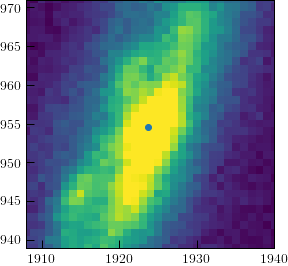

In [16]:
gxmin, gxmax = int(round(gx, 0))-pix_sz, int(round(gx, 0))+pix_sz
gymin, gymax = int(round(gy, 0))-pix_sz, int(round(gy, 0))+pix_sz

plt.imshow(gband[0].data, vmin=0.006, vmax=0.8)
plt.scatter(gx, gy)
plt.gca().invert_yaxis()
plt.xlim(gxmin, gxmax)
plt.ylim(gymin, gymax)
plt.show()

In [17]:
# x and y range defining the N x N pixel image
uxmin, uxmax = int(round(ux, 0))-pix_sz, int(round(ux, 0))+pix_sz
uymin, uymax = int(round(uy, 0))-pix_sz, int(round(uy, 0))+pix_sz

gxmin, gxmax = int(round(gx, 0))-pix_sz, int(round(gx, 0))+pix_sz
gymin, gymax = int(round(gy, 0))-pix_sz, int(round(gy, 0))+pix_sz

rxmin, rxmax = int(round(rx, 0))-pix_sz, int(round(rx, 0))+pix_sz
rymin, rymax = int(round(ry, 0))-pix_sz, int(round(ry, 0))+pix_sz

ixmin, ixmax = int(round(ix, 0))-pix_sz, int(round(ix, 0))+pix_sz
iymin, iymax = int(round(iy, 0))-pix_sz, int(round(iy, 0))+pix_sz

zxmin, zxmax = int(round(zx, 0))-pix_sz, int(round(zx, 0))+pix_sz
zymin, zymax = int(round(zy, 0))-pix_sz, int(round(zy, 0))+pix_sz

In [18]:
# Potentially useful info for vmin, vmax in imshow(), but not necessary for cropping image
print (np.min(uband[0].data.flatten()), np.max(uband[0].data.flatten()))
print (np.min(gband[0].data.flatten()), np.max(gband[0].data.flatten()))
print (np.min(rband[0].data.flatten()), np.max(rband[0].data.flatten()))
print (np.min(iband[0].data.flatten()), np.max(iband[0].data.flatten()))
print (np.min(zband[0].data.flatten()), np.max(zband[0].data.flatten()))

ulev = np.percentile(uband[0].data.flatten(), [16, 50, 84])
glev = np.percentile(gband[0].data.flatten(), [16, 50, 84])
rlev = np.percentile(rband[0].data.flatten(), [16, 50, 84])
ilev = np.percentile(iband[0].data.flatten(), [16, 50, 84])
zlev = np.percentile(zband[0].data.flatten(), [16, 50, 84])

print (ulev, glev, rlev, ilev, zlev)

-0.2084961 287.5
-0.09289551 177.0
-0.13183594 221.5
-0.24023438 115.125
-1.1269531 1920.0
[-0.0411377   0.00216293  0.04534912] [-0.01782227 -0.00014567  0.02017212] [-0.02670288  0.00140381  0.02984619] [-0.04351807  0.00093651  0.05029297] [-0.20996094  0.01205444  0.23486328]


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


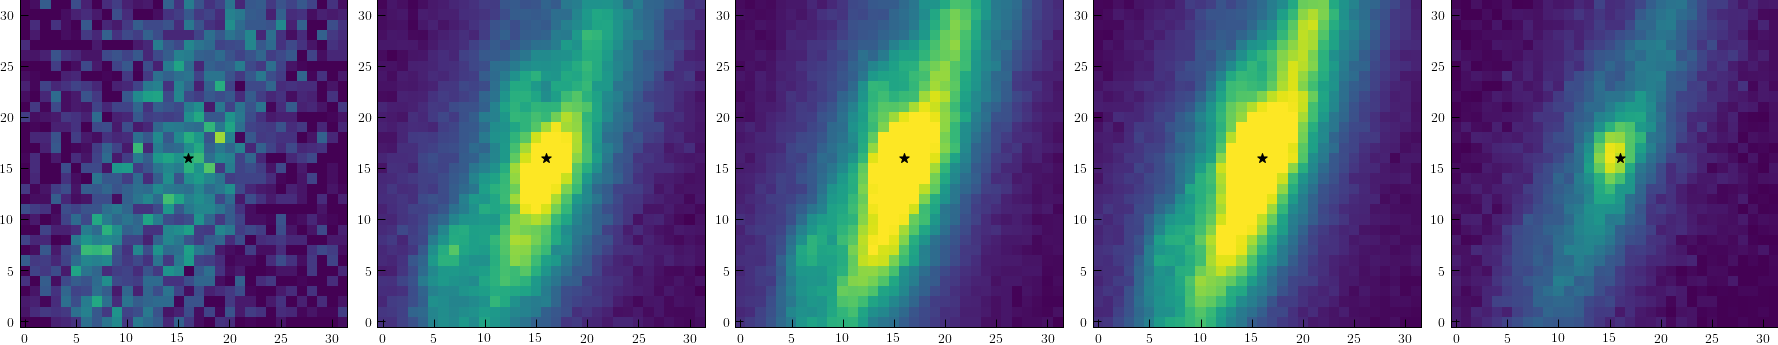

In [19]:
# Plot cropped ugriz images with central pixel of galaxy in that band
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))

ax1.imshow(uband[0].data[uymin:uymax, uxmin:uxmax], vmin=0.002, vmax=0.4)
ax1.scatter(pix_sz, pix_sz, marker='*', color='black', s=100)
ax1.invert_yaxis()

ax2.imshow(gband[0].data[gymin:gymax, gxmin:gxmax], vmin=0.0001, vmax=1.0)
ax2.scatter(pix_sz, pix_sz, marker='*', color='black', s=100)
ax2.invert_yaxis()

ax3.imshow(rband[0].data[rymin:rymax, rxmin:rxmax], vmin=0.002, vmax=2.0)
ax3.scatter(pix_sz, pix_sz, marker='*', color='black', s=100)
ax3.invert_yaxis()

ax4.imshow(iband[0].data[iymin:iymax, ixmin:ixmax], vmin=0.001, vmax=3.0)
ax4.scatter(pix_sz, pix_sz, marker='*', color='black', s=100)
ax4.invert_yaxis()

ax5.imshow(zband[0].data[zymin:zymax, zxmin:zxmax], vmin=0.002, vmax=10.)
ax5.scatter(pix_sz, pix_sz, marker='*', color='black', s=100)
ax5.invert_yaxis()

#fig.savefig('J0943p0024/J0943p0024_ugriz_32x32.pdf')
fig.show()

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


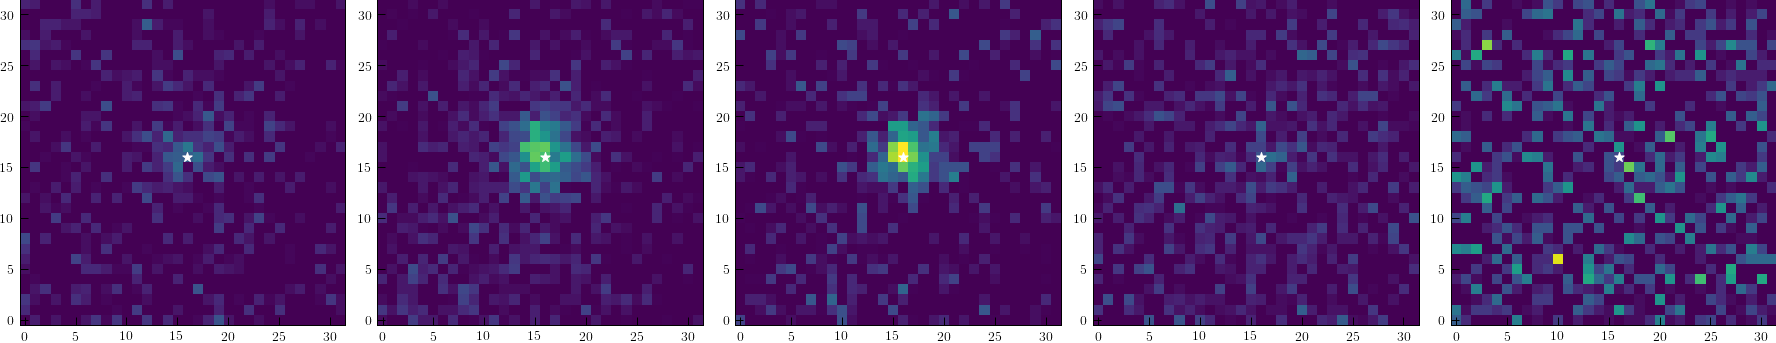

In [74]:
# Plot cropped ugriz images with central pixel of galaxy in that band
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))

ax1.imshow(uband[0].data[uymin:uymax, uxmin:uxmax], vmin=0.02, vmax=0.4)
ax1.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax1.invert_yaxis()

ax2.imshow(gband[0].data[gymin:gymax, gxmin:gxmax], vmin=0.01, vmax=0.2)
ax2.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax2.invert_yaxis()

ax3.imshow(rband[0].data[rymin:rymax, rxmin:rxmax], vmin=0.02, vmax=0.2)
ax3.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax3.invert_yaxis()

ax4.imshow(iband[0].data[iymin:iymax, ixmin:ixmax], vmin=0.01, vmax=0.4)
ax4.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax4.invert_yaxis()

ax5.imshow(zband[0].data[zymin:zymax, zxmin:zxmax], vmin=0.002, vmax=0.8)
ax5.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax5.invert_yaxis()

#fig.savefig('LittleCub/LittleCub_ugriz_32x32.pdf')
fig.show()

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


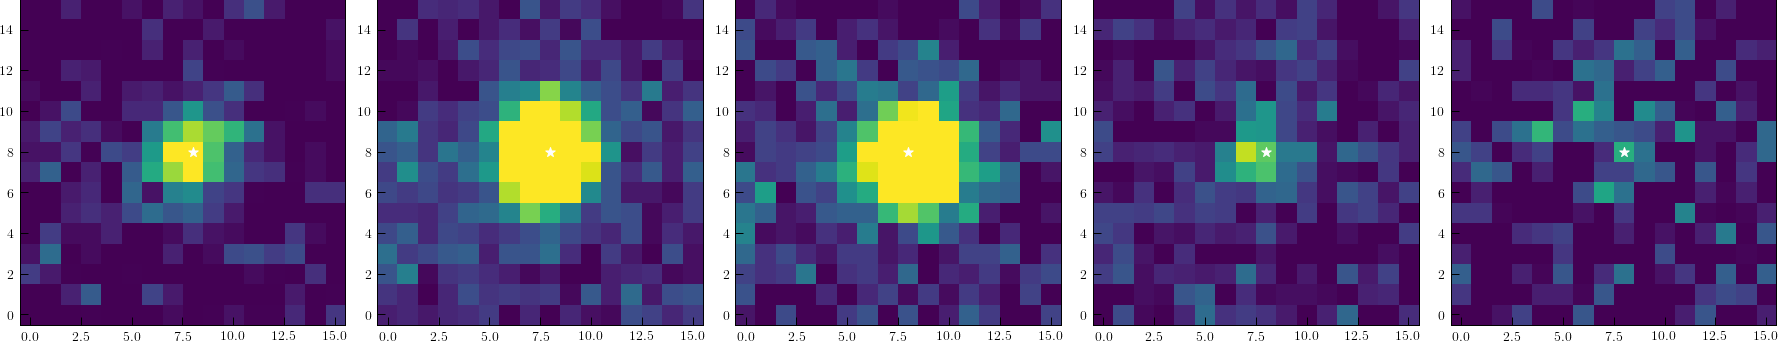

In [87]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))

ax1.imshow(uband[0].data[uymin:uymax, uxmin:uxmax], vmin=0.02, vmax=0.4)
ax1.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax1.invert_yaxis()

ax2.imshow(gband[0].data[gymin:gymax, gxmin:gxmax], vmin=0.01, vmax=0.2)
ax2.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax2.invert_yaxis()

ax3.imshow(rband[0].data[rymin:rymax, rxmin:rxmax], vmin=0.02, vmax=0.2)
ax3.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax3.invert_yaxis()

ax4.imshow(iband[0].data[iymin:iymax, ixmin:ixmax], vmin=0.01, vmax=0.4)
ax4.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax4.invert_yaxis()

ax5.imshow(zband[0].data[zymin:zymax, zxmin:zxmax], vmin=0.002, vmax=0.6)
ax5.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax5.invert_yaxis()

#fig.savefig('LeoP/LeoP_ugriz_16x16.pdf')
fig.show()

## Stack ugriz flux values in the 64 x 64 cropped image

In [20]:
stack_img = np.zeros((2*pix_sz, 2*pix_sz, 5))

In [21]:
stack_img[:, :, 0] = uband[0].data[uymin:uymax, uxmin:uxmax]
stack_img[:, :, 1] = gband[0].data[gymin:gymax, gxmin:gxmax]
stack_img[:, :, 2] = rband[0].data[rymin:rymax, rxmin:rxmax]
stack_img[:, :, 3] = iband[0].data[iymin:iymax, ixmin:ixmax]
stack_img[:, :, 4] = zband[0].data[zymin:zymax, zxmin:zxmax]

## Test stacking multiple images

In [22]:
(2*pix_sz)**2*5

5120

In [23]:
N_gal = 3
all_imgs = np.zeros((N_gal, 2*pix_sz, 2*pix_sz, 5))

In [24]:
all_imgs[0] = stack_img
#all_imgs[1] = stack_img.flatten()
#all_imgs[2] = stack_img.flatten()

In [26]:
all_imgs.shape

(3, 32, 32, 5)

## Save ugriz flux values in flattened array

In [27]:
np.save('test_output_Xtrain_format', all_imgs)

## Test reading in the flattened array(s) and reshaping

In [35]:
X_train = np.load('test_output_Xtrain_format.npy')

In [36]:
X_train.shape

(3, 32, 32, 5)

In [37]:
X_train[0]

array([[[-0.02682495,  0.14379883,  0.27050781,  0.43310547,
          0.75097656],
        [ 0.00226974,  0.14379883,  0.34667969,  0.47705078,
          0.4921875 ],
        [ 0.00226974,  0.19873047,  0.40820312,  0.66601562,
          0.8984375 ],
        ...,
        [ 0.0022583 ,  0.03018188,  0.06713867,  0.11950684,
          0.0489502 ],
        [-0.01228333,  0.02331543,  0.09545898,  0.02520752,
         -0.09899902],
        [ 0.01678467,  0.03704834,  0.00554657,  0.03149414,
         -0.20996094]],

       [[ 0.02407837,  0.1574707 ,  0.22802734,  0.33300781,
          0.75097656],
        [ 0.05316162,  0.16430664,  0.25634766,  0.3515625 ,
          0.45556641],
        [ 0.06774902,  0.1953125 ,  0.39355469,  0.58398438,
          1.12109375],
        ...,
        [ 0.00952148,  0.01986694,  0.043396  ,  0.06921387,
          0.0489502 ],
        [ 0.00952148,  0.02331543,  0.02920532,  0.06286621,
          0.15991211],
        [ 0.07495117,  0.05084229,  0.09545898, 

# galSpec and emlinePort query results

In [238]:
# Load this table
# Find indices where subclass = 'STARFORMING' or 'STARBURST'
# Find indices where reliable is 1, z_warning is 0, uimg is not null
# Set # of total galaxies to be length of those that qualify in ^^ criteria

## Load .csv tables

Read in complete list of galaxies returned from galSpec and emlinePort queries for z < 0.1 galaxies with at least 3-sigma detections on [NII] and [SII]

In [161]:
galspec = pd.read_csv('galspec_RS_uimg.csv', delimiter=',')
emline = pd.read_csv('emlineport_RS_uimg.csv', delimiter=',')

In [162]:
galspec.columns

Index(['specObjID', 'oii_3726_flux', 'oii_3726_flux_err', 'oii_3729_flux',
       'oii_3729_flux_err', 'oiii_4363_flux', 'oiii_4363_flux_err',
       'h_beta_flux', 'h_beta_flux_err', 'oiii_4959_flux',
       'oiii_4959_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err',
       'h_alpha_flux', 'h_alpha_flux_err', 'nii_6548_flux',
       'nii_6548_flux_err', 'nii_6584_flux', 'nii_6584_flux_err',
       'sii_6717_flux', 'sii_6717_flux_err', 'sii_6731_flux',
       'sii_6731_flux_err', 'ra', 'dec', 'z', 'z_err', 'z_warning',
       'targettype', 'spectrotype', 'subclass', 'sn_median', 'reliable', 'run',
       'camcol', 'field', 'uimg'],
      dtype='object')

In [163]:
emline.columns

Index(['specObjID', 'ra', 'dec', 'z', 'zErr', 'redshift', 'bpt',
       'Flux_OII_3726', 'Flux_OII_3726_Err', 'Flux_OII_3728',
       'Flux_OII_3728_Err', 'Flux_OIII_4363', 'Flux_OIII_4363_Err',
       'Flux_OIII_4958', 'Flux_OIII_4958_Err', 'Flux_OIII_5006',
       'Flux_OIII_5006_Err', 'Flux_Hb_4861', 'Flux_Hb_4861_Err',
       'Flux_Ha_6562', 'Flux_Ha_6562_Err', 'Flux_NII_6547',
       'Flux_NII_6547_Err', 'Flux_NII_6583', 'Flux_NII_6583_Err',
       'Flux_SII_6716', 'Flux_SII_6716_Err', 'Flux_SII_6730',
       'Flux_SII_6730_Err', 'run', 'camcol', 'field', 'uimg'],
      dtype='object')

In [164]:
galspec.head()

,specObjID,oii_3726_flux,oii_3726_flux_err,oii_3729_flux,oii_3729_flux_err,oiii_4363_flux,oiii_4363_flux_err,h_beta_flux,h_beta_flux_err,oiii_4959_flux,...,z_warning,targettype,spectrotype,subclass,sn_median,reliable,run,camcol,field,uimg
0,299489676975171584,307.00140,2327.571000,34.05977,159.323600,2.330947,6.684836,98.78678,6.727546,30.881300,...,0,GALAXY,GALAXY,NaN,38.082610,1,756.0,1.0,206.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
1,299489677444933632,0.00000,-0.764372,0.00000,-0.764372,14.544610,6.551525,119.49560,6.650275,24.923760,...,0,GALAXY,GALAXY,STARFORMING,39.110620,1,756.0,1.0,206.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
2,299490502078654464,39.05738,7.645567,27.09657,7.928473,0.903860,3.333012,25.64047,2.906838,9.876856,...,0,GALAXY,GALAXY,STARFORMING,18.075250,1,1239.0,2.0,175.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
3,299491051364706304,29.87828,6.475568,19.59231,6.553017,-1.443974,3.117991,47.36650,3.055110,0.172112,...,0,GALAXY,GALAXY,STARBURST,5.252150,1,NaN,NaN,NaN,NaN
4,299491051834468352,48.75391,5.241384,47.94999,5.445445,-6.008739,2.396007,38.33226,2.279489,12.637830,...,0,GALAXY,GALAXY,STARFORMING,8.069353,1,756.0,1.0,206.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...


In [165]:
emline.head()

,specObjID,ra,dec,z,zErr,redshift,bpt,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,...,Flux_NII_6583,Flux_NII_6583_Err,Flux_SII_6716,Flux_SII_6716_Err,Flux_SII_6730,Flux_SII_6730_Err,run,camcol,field,uimg
0,299489676975171584,146.71421,-1.041304,0.021275,0.000009,0.021529,Star Forming,0.00000,0.00000,7.980984e+02,...,459.40470,30.414420,185.84740,31.328970,184.65060,33.967490,756.0,1.0,206.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
1,299489677444933632,146.71421,-1.041304,0.021222,0.000009,0.021484,Star Forming,0.00000,0.00000,2.302374e+06,...,414.17850,25.240040,206.76410,25.045110,130.87280,22.694970,756.0,1.0,206.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
2,299490502078654464,146.62857,-0.765137,0.064656,0.000021,0.064890,Composite,192.23790,52.48717,7.094870e+01,...,138.55290,12.427430,70.53356,9.671746,38.17468,9.670739,1239.0,2.0,175.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
3,299491051364706304,146.96390,-0.545003,0.055988,0.000011,0.055987,Star Forming,25.62198,11.37271,2.567438e+01,...,35.90083,4.514204,19.72136,3.160789,14.70105,3.771800,NaN,NaN,NaN,NaN
4,299491051834468352,146.63167,-0.988278,0.052654,0.000009,0.052906,Star Forming,116.96290,52.59673,5.139409e+01,...,37.52691,4.169205,44.60871,4.826180,36.42942,4.450006,756.0,1.0,206.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...


In [166]:
galspec.subclass.unique(), emline.bpt.unique()

(array([nan, 'STARFORMING', 'STARBURST', 'BROADLINE', 'AGN',
        'STARFORMING BROADLINE', 'AGN BROADLINE', 'G2',
        'STARBURST BROADLINE', 'F5', 'A0', 'F9', 'M0', 'L5.5', 'M2', 'G0',
        'M0V', 'K3', 'K5', 'K7', 'Carbon', 'Carbon_lines', 'L5', 'O', 'M6',
        'OB', 'WD', 'M4', 'M5', 'T2', 'A0p', 'L9', 'K1', 'M1', 'B9', 'M3',
        'CarbonWD', 'L1', 'F2', 'B6', 'G5', 'CV'], dtype=object),
 array(['Star Forming', 'Composite', 'LINER', 'Seyfert', 'BLANK',
        'Seyfert/LINER'], dtype=object))

## Prune tables to remove duplicates and NaNs

Drop all rows (axis=0) that are duplicate galaxies OR with a NaN in *any* column.

galSpec: there are galaxies that appear more than once in the table. Also, a check of original file finds that NaNs appear only in columns 'subclass', 'run', 'camcol', 'field', and/or 'uimg'. Doing this removes 55940 galaxies, dropping us from 252456 to 196516.

emlinePort: there are galaxies that appear more than once in the table. Also, a check of original file finds that NaNs appear only in columns 'run', 'camcol', 'field', and/or 'umg'. Doing this removes 17335 galaxies, taking us from 210163 to 192828.

In [167]:
galspec_complete = galspec.drop_duplicates(subset=('ra', 'dec')).dropna(axis=0).reset_index()
emline_complete = emline.drop_duplicates(subset=('ra', 'dec')).dropna(axis=0).reset_index()

## Prune table to keep only starforming galaxies

galspec: 180887 STARFORMING or STARBURST galaxies

emline: 161813 Star Forming galaxies

In [168]:
galspec_sf = galspec_complete[(galspec_complete['subclass'] == 'STARFORMING') | (galspec_complete['subclass'] == 'STARBURST')].reset_index(drop=True)
emline_sf = emline_complete[(emline_complete['bpt'] == 'Star Forming')].reset_index(drop=True)

## Prune table to remove entries where [NII], Ha flux or error is < 0.0

galSpec: loses 8+102 = 110 entries from 180887 --> 180777 --> 180391
    * Ha flux values < 0.0 for 8 entries, and an additional 102 entries where Ha flux errors < 0.0 (negative Ha flux and Ha errors do not overlap)
        
    * [NII] 6548, 6584 flux values are all ok (> 0.0) , but there are 102 entries where the flux errors are negative (same 102 as negative Ha flux errors)
    
    * Additional losses due to unreliable redshift (if 'z_warning' is non-zero) or spectra (if 'reliable' is not 1)

emline: loses 7 entries from 161813 --> 161806
    * Ha flux values < 0.0 for 7 entries, all Ha flux errors are ok
    * [NII] flux values and errors are all ok

Note on redshift:
    * galSpec has 13 galaxies with negative redshifts
    * emline has 0 galaxies with negative 'z', but 2 galaxies with negative 'redshift', which is the GANDALF-corrected redshift values

In [197]:
emline_sf['z'][emline_sf['redshift'] < 0.]

33050    0.000036
92972    0.000056
Name: z, dtype: float64

In [193]:
galspec_sf['z'][galspec_sf['z'] < 0.]

13613    -0.000016
101886   -0.000515
101929   -0.000528
101937   -0.000270
101938   -0.000552
102077   -0.001445
102170   -0.000010
102175   -0.000457
115030   -0.000833
115033   -0.000619
115091   -0.000642
115312   -0.000421
126089   -0.000031
Name: z, dtype: float64

In [233]:
galspec_final = galspec_sf[(galspec_sf['h_alpha_flux'] > 0.0) & (galspec_sf['h_alpha_flux_err'] > 0.0)
                           & (galspec_sf['reliable'] == 1) & (galspec_sf['z_warning'] == 0)].reset_index(drop=True)
emline_final = emline_sf[emline_sf['Flux_Ha_6562'] > 0.0].reset_index(drop=True)

In [234]:
print (len(galspec_sf), len(galspec_final))
print (len(emline_sf), len(emline_final))

180887 180391
161813 161806


In [368]:
galspec_direct = galspec_final[(galspec_final['oii_3726_flux'] > 0.0) & (galspec_final['oii_3729_flux'] > 0.0)
              & (galspec_final['oii_3726_flux_err'] > 0.0) & (galspec_final['oii_3729_flux_err'] > 0.0)
              & (galspec_final['oiii_4363_flux'] > 0.0) & (galspec_final['oiii_4363_flux_err'] > 0.0)
              & (galspec_final['oiii_4959_flux'] > 0.0) & (galspec_final['oiii_4959_flux_err'] > 0.0)
              & (galspec_final['oiii_5007_flux'] > 0.0) & (galspec_final['oiii_5007_flux_err'] > 0.0)].reset_index(drop=True)

emline_direct = emline_final[(emline_final['Flux_OII_3726'] > 0.0) & (emline_final['Flux_OII_3726_Err'] > 0.0)
              & (emline_final['Flux_OII_3728'] > 0.0) & (emline_final['Flux_OII_3728_Err'] > 0.0)
              & (emline_final['Flux_OIII_4363'] > 0.0) & (emline_final['Flux_OIII_4363_Err'] > 0.0)
              & (emline_final['Flux_OIII_4958'] > 0.0) & (emline_final['Flux_OIII_4958_Err'] > 0.0)
              & (emline_final['Flux_OIII_5006'] > 0.0) & (emline_final['Flux_OIII_5006_Err'] > 0.0)].reset_index(drop=True)

In [369]:
len(galspec_direct), len(emline_direct)

(98127, 41333)

In [371]:
print ('galSpec 2-sig:', len(np.where(galspec_direct['oiii_4363_flux'] / galspec_direct['oiii_4363_flux_err'] > 2.)[0]))
print ('galSpec 3-sig:', len(np.where(galspec_direct['oiii_4363_flux'] / galspec_direct['oiii_4363_flux_err'] > 3.)[0]))
print ('emline 2-sig:', len(np.where(emline_direct['Flux_OIII_4363'] / emline_direct['Flux_OIII_4363_Err'] > 2.)[0]))
print ('emline 2-sig:', len(np.where(emline_direct['Flux_OIII_4363'] / emline_direct['Flux_OIII_4363_Err'] > 3.)[0]))

galSpec 2-sig: 11846
galSpec 3-sig: 2896
emline 2-sig: 1667
emline 2-sig: 593


In [235]:
galspec_final.to_csv('galspec_sf_final', columns=['specObjID', 'oii_3726_flux', 'oii_3726_flux_err',
       'oii_3729_flux', 'oii_3729_flux_err', 'oiii_4363_flux',
       'oiii_4363_flux_err', 'h_beta_flux', 'h_beta_flux_err',
       'oiii_4959_flux', 'oiii_4959_flux_err', 'oiii_5007_flux',
       'oiii_5007_flux_err', 'h_alpha_flux', 'h_alpha_flux_err',
       'nii_6548_flux', 'nii_6548_flux_err', 'nii_6584_flux',
       'nii_6584_flux_err', 'sii_6717_flux', 'sii_6717_flux_err',
       'sii_6731_flux', 'sii_6731_flux_err', 'ra', 'dec', 'z', 'z_err',
       'z_warning', 'targettype', 'spectrotype', 'subclass', 'sn_median',
       'reliable', 'run', 'camcol', 'field', 'uimg'], index=False)

emline_final.to_csv('emline_sf_final', columns=['specObjID', 'ra', 'dec', 'z', 'zErr', 'redshift', 'bpt',
       'Flux_OII_3726', 'Flux_OII_3726_Err', 'Flux_OII_3728',
       'Flux_OII_3728_Err', 'Flux_OIII_4363', 'Flux_OIII_4363_Err',
       'Flux_OIII_4958', 'Flux_OIII_4958_Err', 'Flux_OIII_5006',
       'Flux_OIII_5006_Err', 'Flux_Hb_4861', 'Flux_Hb_4861_Err',
       'Flux_Ha_6562', 'Flux_Ha_6562_Err', 'Flux_NII_6547',
       'Flux_NII_6547_Err', 'Flux_NII_6583', 'Flux_NII_6583_Err',
       'Flux_SII_6716', 'Flux_SII_6716_Err', 'Flux_SII_6730',
       'Flux_SII_6730_Err', 'run', 'camcol', 'field', 'uimg'], index=False)#,float_format='%.7f') 

### Look at distribution of [NII]/Ha ratios

In [236]:
galspec_NIIHa = (galspec_final['nii_6548_flux'] + galspec_final['nii_6584_flux']) / galspec_final['h_alpha_flux']
emline_NIIHa = (emline_final['Flux_NII_6547'] + emline_final['Flux_NII_6583']) / emline_final['Flux_Ha_6562']

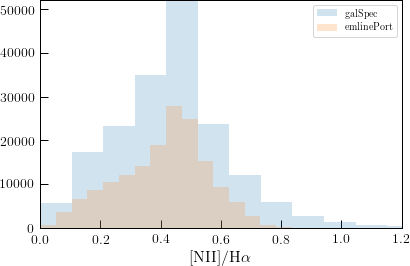

In [237]:
plt.hist(galspec_NIIHa, bins=30, alpha=0.2, label='galSpec')
plt.hist(emline_NIIHa, bins=30, alpha=0.2, label='emlinePort')
plt.xlim(0., 1.2)
plt.xlabel(r'[NII]/H$\alpha$')
plt.legend()
plt.show()

# Download all ugriz .fits files and unzip

In [239]:
Ngal_galspec = len(galspec_final)
Ngal_emline = len(emline_final)

print (Ngal_galspec, Ngal_emline)

180391 161806


## Download

Create .txt file with links to the ugriz .fits files. Typing 'wget -nc -i galspec_dwnld_fits' in the command line will get the downloads started:

    * -nc: no clobber, skip downloads that would download to existing files (overwriting them)
    * -i: input-file = FILE, download URLs found in local or external FILE

In [338]:
# Write a file named 'galspec_dwnld_fits' with links to all the ugriz .fits files
f = open('galspec_dwnld_fits', 'w')

for i in range(0,10):#Ngal_galspec):
    f.write(galspec_final['uimg'][i] + '\n')
    f.write(galspec_final['uimg'][i].replace('frame-u', 'frame-g') + '\n')
    f.write(galspec_final['uimg'][i].replace('frame-u', 'frame-r') + '\n')
    f.write(galspec_final['uimg'][i].replace('frame-u', 'frame-i') + '\n')
    f.write(galspec_final['uimg'][i].replace('frame-u', 'frame-z') + '\n')

f.close()

## Unzip, save unzipped file, remove zipped file

Don't need to unzip!!!!

In [273]:
import os, bz2

## Open ugriz .fits files for each galaxy and save fluxes into an array

In [347]:
import datetime
import warnings
warnings.filterwarnings('ignore')

In [297]:
pix_sz = 16

galspec_flux = np.zeros((Ngal_galspec, 2*pix_sz, 2*pix_sz, 5))
emline_flux = np.zeros((Ngal_emline, 2*pix_sz, 2*pix_sz, 5))

In [377]:
for i in range(0,10):#Ngal_galspec):
    start = datetime.datetime.now()
    
    # Save name of the u-band .fits file
    u_frame = galspec_final['uimg'][i].split('/')[-1] #.strip('.bz2')
    print ('Working on galaxy', i, ':', u_frame, '\n')
    

    # Open ugriz .fits files, replacing letter 'u' in uframe with the respective bands
    print ('\t Loading .fits files and coords')
    uband = fits.open(u_frame)
    gband = fits.open(u_frame.replace('-u-', '-g-'))
    rband = fits.open(u_frame.replace('-u-', '-r-'))
    iband = fits.open(u_frame.replace('-u-', '-i-'))
    zband = fits.open(u_frame.replace('-u-', '-z-'))
    
    coords = SkyCoord(galspec_final['ra'][i], galspec_final['dec'][i], unit=(u.deg, u.deg))
    
    # Calculate the center of the galaxy in (x, y) pixel values given the RA, DEC
    print ('\t Calculating central pixels and cropping to 32x32 box')
    ux, uy = wcs.utils.skycoord_to_pixel(coords, wcs.WCS(uband[0].header))
    gx, gy = wcs.utils.skycoord_to_pixel(coords, wcs.WCS(gband[0].header))
    rx, ry = wcs.utils.skycoord_to_pixel(coords, wcs.WCS(rband[0].header))
    ix, iy = wcs.utils.skycoord_to_pixel(coords, wcs.WCS(iband[0].header))
    zx, zy = wcs.utils.skycoord_to_pixel(coords, wcs.WCS(zband[0].header))
    
    #print (ux, uy)
    #print (gx, gy)
    #print (rx, ry)
    #print (ix, iy)
    #print (zx, zy)
    
    # x and y range defining the 32x32 pixel image
    uxmin, uxmax = int(np.round(ux))-pix_sz, int(np.round(ux, 0))+pix_sz
    uymin, uymax = int(np.round(uy, 0))-pix_sz, int(np.round(uy, 0))+pix_sz

    gxmin, gxmax = int(np.round(gx, 0))-pix_sz, int(np.round(gx, 0))+pix_sz
    gymin, gymax = int(np.round(gy, 0))-pix_sz, int(np.round(gy, 0))+pix_sz

    rxmin, rxmax = int(np.round(rx, 0))-pix_sz, int(np.round(rx, 0))+pix_sz
    rymin, rymax = int(np.round(ry, 0))-pix_sz, int(np.round(ry, 0))+pix_sz

    ixmin, ixmax = int(np.round(ix, 0))-pix_sz, int(np.round(ix, 0))+pix_sz
    iymin, iymax = int(np.round(iy, 0))-pix_sz, int(np.round(iy, 0))+pix_sz

    zxmin, zxmax = int(np.round(zx, 0))-pix_sz, int(np.round(zx, 0))+pix_sz
    zymin, zymax = int(np.round(zy, 0))-pix_sz, int(np.round(zy, 0))+pix_sz
    
    print ('\t Saving flux values')
    galspec_flux[i, :, :, 0] = uband[0].data[uymin:uymax, uxmin:uxmax]
    galspec_flux[i, :, :, 1] = gband[0].data[gymin:gymax, gxmin:gxmax]
    galspec_flux[i, :, :, 2] = rband[0].data[rymin:rymax, rxmin:rxmax]
    galspec_flux[i, :, :, 3] = iband[0].data[iymin:iymax, ixmin:ixmax]
    galspec_flux[i, :, :, 4] = zband[0].data[zymin:zymax, zxmin:zxmax]
    
    end = datetime.datetime.now()
    print ('\t Took', (end-start).microseconds/1e6, 'seconds \n')

print ('Saving galspec_flux...!')

start = datetime.datetime.now()
np.save('galspec_flux', galspec_flux)

print ('Deleting .fits files..!')
for item in os.listdir(dir_name):
    if item.endswith('.fits.bz2'):
        os.remove(item)

end = datetime.datetime.now()
print (end-start)

Working on galaxy 0 : frame-u-001239-2-0175.fits.bz2 

	 Loading .fits files and coords
	 Calculating central pixels and cropping to 32x32 box
	 Saving flux values
	 Took 0.823929 seconds 

Working on galaxy 1 : frame-u-000756-1-0206.fits.bz2 

	 Loading .fits files and coords
	 Calculating central pixels and cropping to 32x32 box
	 Saving flux values
	 Took 0.70085 seconds 

Working on galaxy 2 : frame-u-001239-2-0175.fits.bz2 

	 Loading .fits files and coords
	 Calculating central pixels and cropping to 32x32 box
	 Saving flux values
	 Took 0.982933 seconds 

Working on galaxy 3 : frame-u-001239-3-0179.fits.bz2 

	 Loading .fits files and coords
	 Calculating central pixels and cropping to 32x32 box
	 Saving flux values
	 Took 0.355117 seconds 

Working on galaxy 4 : frame-u-001239-4-0180.fits.bz2 

	 Loading .fits files and coords
	 Calculating central pixels and cropping to 32x32 box
	 Saving flux values
	 Took 0.714665 seconds 

Working on galaxy 5 : frame-u-000756-1-0205.fits.bz

Takes 0.1 seconds/galaxy to open .fits files, crop, and save flux values

Takes 25 seconds to save .npy file of flux values

In [122]:
# For each galaxy:
# Take uimg, replace 'frame-u' with 'frame-g', 'frame-r', 'frame-i', and 'frame-z'
# Write into a file 'wget frame-u', 'wget frame-g', etc. ... to download all .fits files
# Unzip files

#### unsure if unzip should/can be done in script. Maybe separate scripts here?
#### need to relate the uimg link with the downloaded file name, which is still by
####    frame-u-00run#-camcol#-00field#

# For each galaxy:
# Given the index, create string with run#, camcol#, field# to build name of ugriz .fits files
# Read in 5 ugriz .fits files
# Take RA, DEC and find (x, y) pixel center
# take -16 to +16 box aorund (x, y) center
# stack image and place into all_imgs

In [378]:
X_train = np.load('galspec_flux.npy')

In [379]:
X_train[0]

array([[[ 9.35363770e-03,  2.18200684e-02, -2.36129761e-03,
         -1.31835938e-02, -2.23388672e-01],
        [-6.68945312e-02, -1.74865723e-02,  2.43377686e-03,
          1.02081299e-02, -3.19335938e-01],
        [ 8.85963440e-04,  2.53906250e-02,  5.52368164e-02,
          1.02081299e-02,  6.09397888e-04],
        ...,
        [-4.15039062e-02, -1.39312744e-02,  7.19451904e-03,
         -2.10571289e-02, -6.34765625e-02],
        [ 9.35363770e-03,  3.93676758e-03,  7.19451904e-03,
          8.04443359e-02,  1.92382812e-01],
        [-3.30200195e-02, -3.20816040e-03,  1.67846680e-02,
          5.70068359e-02,  9.65576172e-02]],

       [[-1.00830078e-01, -1.03302002e-02, -1.67541504e-02,
          1.02081299e-02,  1.60644531e-01],
        [ 1.78222656e-02,  3.95965576e-03,  7.23266602e-03,
          1.02081299e-02, -9.53369141e-02],
        [-4.99877930e-02,  1.11083984e-02, -1.67541504e-02,
         -4.43725586e-02,  2.56347656e-01],
        ...,
        [-5.84716797e-02,  3.6071777